# Clustering 

**In this notebook:**
* Setting up a Spark cluster
* Loading MNIST dataset
* Clustering data with K-means
    * On full dimension
    * On reduced dimension
    * On 2 dimensons

## Imports

In [ ]:
!pip install pyspark

In [322]:
import os
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.clustering import *
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

%matplotlib inline

## Evironment

Connecting to Spark cluster. 

In [97]:
conf = SparkConf().setAppName("HW2").setMaster("local[4]")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=HW2, master=local[8]) created by __init__ at <ipython-input-2-8a5c88863493>:2 

## Data Loading

Loading MNIST data into Spark data frame and transforming to a feature vector.

In [389]:
data_path = "../../../data/HW2/mnist_test.csv"

In [390]:
mnist = (
    sqlContext.read.format("csv")
    .options(
        header="false",
        inferSchema="True",
        delimiter=",",
    )
    .load(os.path.abspath(data_path))
)
mnist = mnist.cache()

In [391]:
print(f"Number of samples: {mnist.count()}")
print(f"Number of elements per sample: {len(mnist.columns)}")
print(f"Width and length of the images: {math.sqrt(len(mnist.columns))}")

Number of samples: 10000
Number of elements per sample: 784
Width and length of the images: 28.0


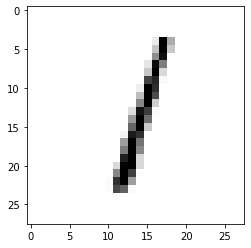

In [392]:
plt.imshow(np.array(mnist.collect()[2]).reshape(28, 28),  cmap='Greys')

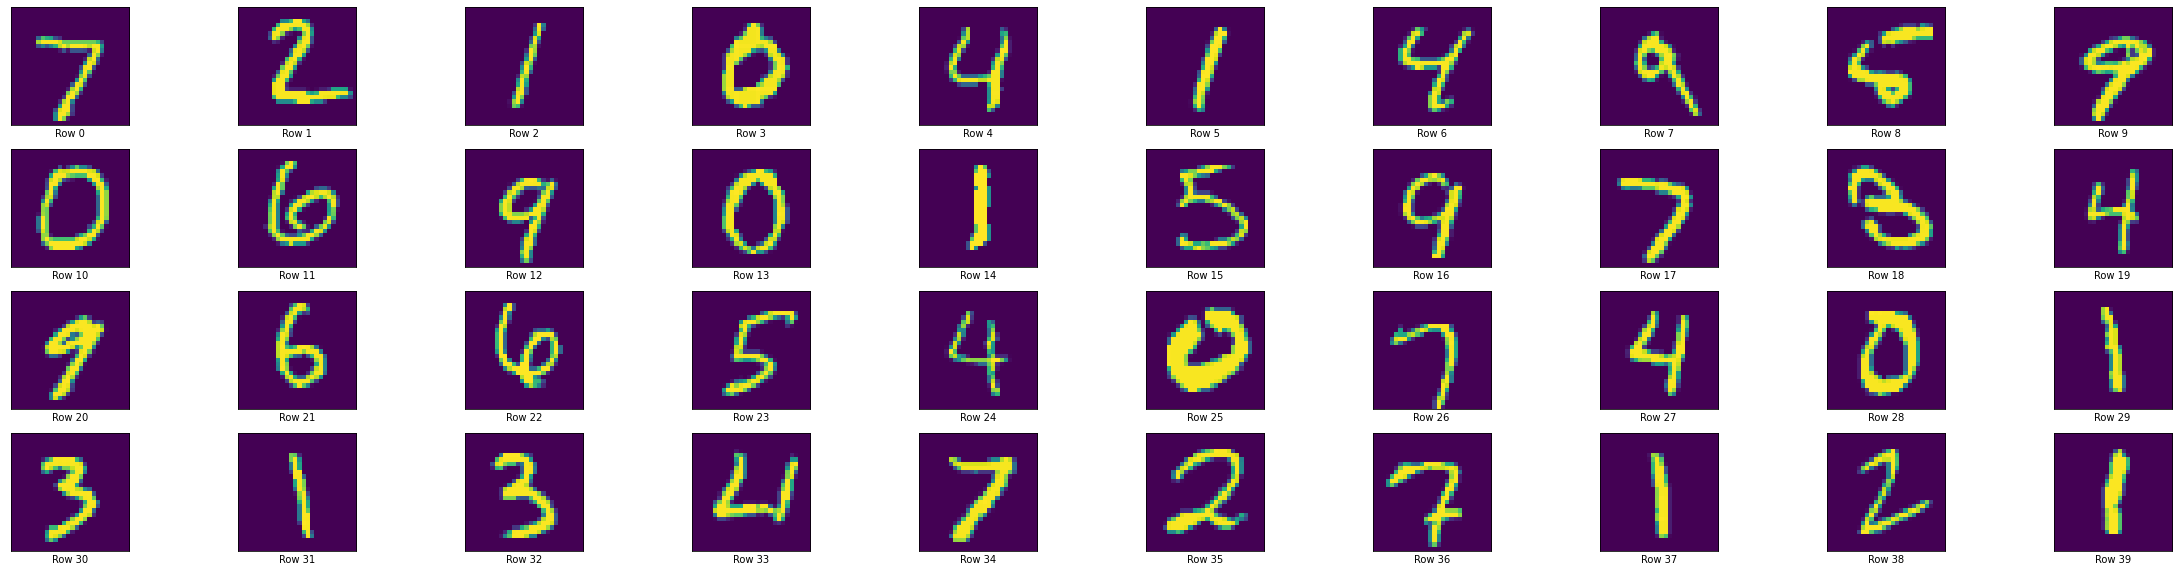

In [393]:
# Plotting Example
rows = mnist.collect()
# Plotting Examples
plt.figure(figsize=(40, 10))
for count, row in enumerate(rows[:40]):

    digits = plt.subplot(4, 10, count + 1)
    digits.imshow(np.array(row).reshape(28, 28), interpolation="nearest")
    digits.set_xticks(())
    digits.set_yticks(())
    digits.set_xlabel("Row %i" % count)
plt.show()

In [394]:
# Vector sampler
assembler = VectorAssembler(inputCols=mnist.columns, outputCol="features")

output = assembler.transform(mnist)

## Clustering with Full Dimension

I have tested different clustering algorithms (Kmeans and BisectingKMeansModel) and parameters (max iteration and seed). Kmeans performed better. 
Also, I tried to set custom cluster centroids, but this is not possible in ML API.

### Training K-Means

In [395]:
# Trains a k-means model.
kmeans = KMeans(
    featuresCol="features",
    k=10,
    seed=17,
    maxIter=0,   # Change Iteration to 15 for training
    initMode="k-means||",
    initSteps=6,
)
model = kmeans.fit(output)

### Vizualize the Centroids

Each cluster has a center. For each sample, the distance to all cluster centers is calculated and assigned to the cluster where the distance is smallest. Since we have 10 classes with images of numbers from 0-9 in the dataset, the cluster centers should cover every number at best. However, the handwritten numbers 9 and 4, and 7 and 1 are very close. 

In [396]:
# Save cluster centers
centers = model.clusterCenters()

with open("output.csv", "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerows(model.clusterCenters())

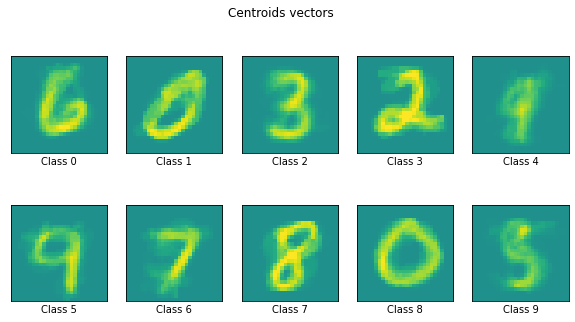

In [397]:
# Visualize cluster centers
plt.figure(figsize=(10, 5))
scale = np.abs(centers).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        centers[i].reshape(28, 28),
        interpolation="nearest",#  cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Centroids vectors")
# Save visualization
plt.savefig("cluster_centers")

^ after 0 iterations. 

max iterations: 
* 1500 is quite good, same as 3000, same as 5000 (with seed 17 and init step 10)
* with init 5,2,3  its worse -> 4 is better 
* max iter 20 is better than 1500 with seed 17 and init step 4

## Clustering on Lower Dimension

In addition to the clustering on full dimension, I also clustered the dataset on lower dimesion. Therefore, I used PCA and visualized the clusteres by reconstructing them to the original size. 

### Lowering Dimension

In [398]:
pca = PCA(k=100, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(output)
pca_features = pca_model.transform(output).select("pcaFeatures")

### Training K-Means

In [399]:
# Trains a k-means model.
kmeans = KMeans(
    featuresCol="pcaFeatures",
    k=10,
    seed=17,
    maxIter=20,
    initMode="k-means||",
    initSteps=6,
)
model = kmeans.fit(pca_features)

### Visualize the Clusters

In [400]:
predictions = model.transform(pca_features)

In [401]:
centers = model.clusterCenters()

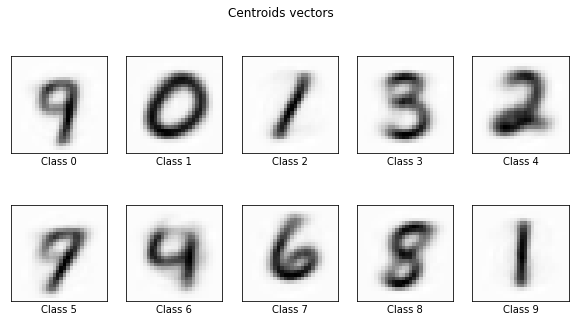

In [402]:
# Visualize cluster centers
plt.figure(figsize=(10, 5))
scale = np.abs(centers).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        np.dot(centers[i], pca_model.pc.toArray().T).reshape(28, 28),
        interpolation="nearest",
        cmap='Greys',
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Centroids vectors")
# Save visualization
plt.savefig("cluster_centers")

## Clustering on Two Dimensions

In other to vizualize the cluster centers in 2d I also reduced the dimension to 2. Here we can see that too much information compared to the original data.

### Lowering Dimension

In [403]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(output)
pca_features = pca_model.transform(output).select("pcaFeatures")

### Training K-Means

In [404]:
# Trains a k-means model.
kmeans = KMeans(
    featuresCol="pcaFeatures",
    k=10,
    seed=17,
    maxIter=15,
    initMode="k-means||",
    initSteps=6,
)
model = kmeans.fit(pca_features)

### Visualize the Clusters

In [405]:
predictions = model.transform(pca_features)

In [406]:
predictions.show(4)

+--------------------+----------+
|         pcaFeatures|prediction|
+--------------------+----------+
|[377.950052424416...|         6|
|[847.276983747232...|         4|
|[-145.89428997909...|         1|
|[2044.87755473737...|         2|
+--------------------+----------+
only showing top 4 rows



In [407]:
centers = model.clusterCenters()

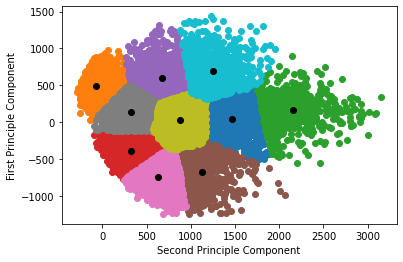

In [408]:
for i in range(10):
    x = predictions[predictions.prediction == i].toPandas()["pcaFeatures"].apply(lambda x: x[0])
    y = predictions[predictions.prediction == i].toPandas()["pcaFeatures"].apply(lambda x: x[1])
    plt.scatter(
    x,y,
    label=f'cluster {i}'
    )
    plt.scatter(
        centers[i][0], centers[i][1], 
        color = 'black'
    )
plt.ylabel("First Principle Component")
plt.xlabel("Second Principle Component")
plt.savefig("cluster_2d")
plt.show()

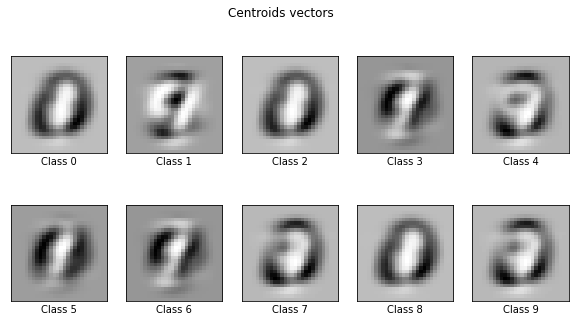

In [409]:
# Visualize cluster centers
plt.figure(figsize=(10, 5))
scale = np.abs(centers).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        np.dot(centers[i], pca_model.pc.toArray().T).reshape(28, 28),
        interpolation="nearest",
        cmap='Greys',
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Centroids vectors")
plt.show()
# Save visualization
#plt.savefig("cluster_centers")